# Modelling

---

In [110]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import datetime
import calendar

from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima_model import ARIMA
from sklearn.metrics import r2_score

import plotly.graph_objects as go

In [2]:
pd.set_option('display.max_columns', None)

In [3]:
daily = pd.read_csv('/Users/stuartdaw/Documents/Capstone_data/data/targets/daily_all.csv', 
                    index_col='date', parse_dates=True)

In [4]:
daily_pattern = pd.read_csv('/Users/stuartdaw/Documents/Capstone_data/data/targets/daily_pattern.csv', 
                           parse_dates=True)

In [5]:
daily.head()

,open,high,low,close,marubozu,marubozu+1,marubozu-1,marubozu-2,height,av_3_height,wk_mv_av,mnth_mv_av,qtr_mv_av,day-1_open,day-2_open,day-3_open,day-1_high,day-2_high,day-3_high,day-1_low,day-2_low,day-3_low,day-1_close,day-2_close,day-3_close,day+1_open,day+1_high,day+1_low,day+1_close,day+2_high,day+3_high,target,select
date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2000-05-30,0.9302,0.9302,0.9302,0.9302,0,1.0,NaN,NaN,0.0000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.9315,0.9382,0.9151,0.9377,0.9380,0.9498,0.9498,0
2000-05-31,0.9315,0.9382,0.9151,0.9377,1,-1.0,0.0,NaN,0.0062,NaN,NaN,NaN,NaN,0.9302,NaN,NaN,0.9302,NaN,NaN,0.9302,NaN,NaN,0.9302,NaN,NaN,0.9376,0.9380,0.9287,0.9315,0.9498,0.9490,0.9498,1
2000-06-01,0.9376,0.9380,0.9287,0.9315,-1,1.0,1.0,0.0,-0.0061,0.000033,NaN,NaN,NaN,0.9315,0.9302,NaN,0.9382,0.9302,NaN,0.9151,0.9302,NaN,0.9377,0.9302,NaN,0.9313,0.9498,0.9308,0.9440,0.9490,0.9603,0.9603,1
2000-06-02,0.9313,0.9498,0.9308,0.9440,1,0.0,-1.0,1.0,0.0127,0.004267,NaN,NaN,NaN,0.9376,0.9315,0.9302,0.9380,0.9382,0.9302,0.9287,0.9151,0.9302,0.9315,0.9377,0.9302,0.9444,0.9490,0.9416,0.9463,0.9603,0.9631,0.9631,0
2000-06-05,0.9444,0.9490,0.9416,0.9463,0,1.0,1.0,-1.0,0.0019,0.002833,NaN,NaN,NaN,0.9313,0.9376,0.9315,0.9498,0.9380,0.9382,0.9308,0.9287,0.9151,0.9440,0.9315,0.9377,0.9462,0.9603,0.9456,0.9535,0.9631,0.9704,0.9704,0


In [25]:
daily_pattern['pattern_end'] = pd.to_datetime(daily_pattern['pattern_end'])

In [26]:
daily_pattern.head()

,pattern_end
0,2000-05-31
1,2000-10-10
2,2001-04-04
3,2001-08-17
4,2001-08-30


In [27]:
daily_pattern.dtypes

pattern_end    datetime64[ns]
dtype: object

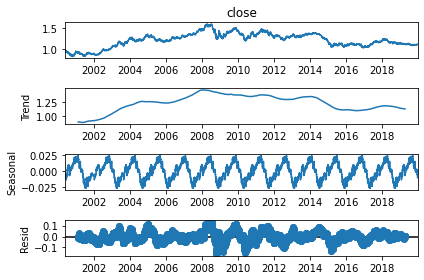

In [28]:
decomposition = seasonal_decompose(daily.close, period=365)  
decomposition.plot();

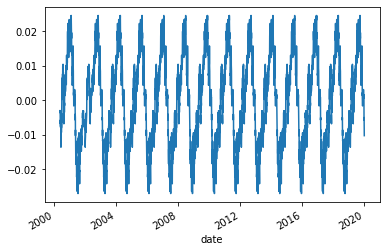

In [29]:
seasonal = decomposition.seasonal 
seasonal.plot()

In [30]:
# Define a Dickey-Fuller test.
from statsmodels.tsa.stattools import adfuller

def test_stationarity(timeseries):

    # Determining rolling statistics:
    rolmean = timeseries.rolling(window=60, center=False).mean()
    rolstd = timeseries.rolling(window=60, center=False).std()

    # Plotting rolling statistics:
    fig = plt.figure(figsize=(12, 8))
    orig = timeseries.plot(color='blue',label='Original')
    mean = rolmean.plot(color='red', label='Rolling Mean')
    std = rolstd.plot(color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show()
    
    # Performing a Dickey-Fuller test:
    print('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries)
    dfoutput = pd.Series(dftest[0:2], index=['Test Statistic','p-value'])
    print(dfoutput )

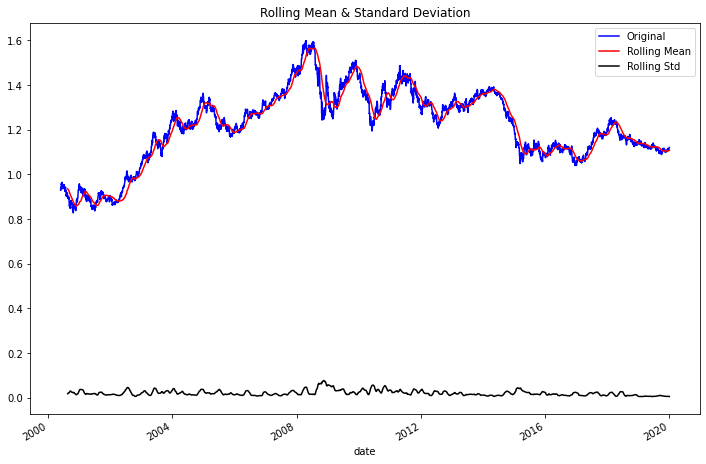

Results of Dickey-Fuller Test:
Test Statistic   -2.081027
p-value           0.252212
dtype: float64


In [31]:
# Perform the test.
test_stationarity(daily['close'])

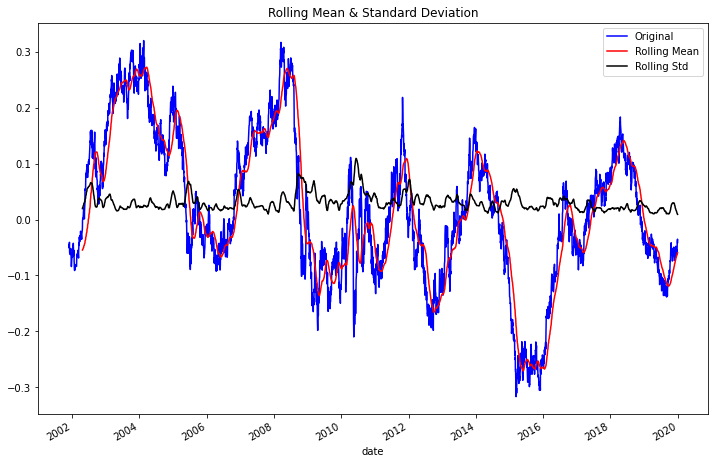

Results of Dickey-Fuller Test:
Test Statistic   -2.798504
p-value           0.058488
dtype: float64


In [32]:
# Seasonal difference:
daily['seasonal_difference'] = daily['close'].diff(365)  
test_stationarity(daily.seasonal_difference.dropna())

In [33]:
# Train test split

In [34]:
type(daily_pattern.iloc[10]['pattern_end'])

pandas._libs.tslibs.timestamps.Timestamp

In [38]:
daily.loc[daily.index == daily_pattern.loc[10]['pattern_end']]

,open,high,low,close,marubozu,marubozu+1,marubozu-1,marubozu-2,height,av_3_height,wk_mv_av,mnth_mv_av,qtr_mv_av,day-1_open,day-2_open,day-3_open,day-1_high,day-2_high,day-3_high,day-1_low,day-2_low,day-3_low,day-1_close,day-2_close,day-3_close,day+1_open,day+1_high,day+1_low,day+1_close,day+2_high,day+3_high,target,select,seasonal_difference
date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2006-01-12,1.2138,1.2165,1.2009,1.204,-1,1.0,1.0,0.0,-0.0098,-0.0007,1.209414,1.192443,1.205351,1.2069,1.2063,1.2144,1.2162,1.2111,1.215,1.2046,1.2039,1.2046,1.2139,1.207,1.2064,1.2039,1.2145,1.2037,1.2136,1.2158,1.2143,1.2158,1,-0.0309


In [62]:
train_stop = daily.loc[daily.index == daily_pattern.loc[10]['pattern_end'] + pd.DateOffset(1)].index[0]

In [63]:
test_stop = daily.loc[daily.index == daily_pattern.loc[10]['pattern_end'] + pd.DateOffset(20)].index[0]

In [120]:
# Train test split
train = daily.loc[:daily.loc[daily.index == daily_pattern.loc[10]['pattern_end'] + pd.DateOffset(1)].index[0]]['close']

test = daily.loc[daily.loc[daily.index == daily_pattern.loc[10]['pattern_end'] + pd.DateOffset(1)].index[0]:
                 daily.loc[daily.index == daily_pattern.loc[10]['pattern_end'] + pd.DateOffset(32)].index[0]]['close']

len(train), len(test)

(1364, 22)

In [121]:
train.describe()

count    1364.000000
mean        1.084413
std         0.156773
min         0.827900
25%         0.917900
50%         1.118200
75%         1.218575
max         1.363400
Name: close, dtype: float64

In [124]:
# Split training data into train values and dates.
train_values = train.values
train_dates = train.index

# Fit model on training data.
#AR1 = AR(train_values, train_dates).fit()

# Split test data into values and dates.
test_values = test.values
test_dates  = test.index

# Create start and end dates for predictions
start = train.index[0]
end = train.index[-1]

# # Create start and end dates for predictions
# start = test.index[0]
# end = test.index[-1]

In [125]:
def train_test_plot(train, test):
    plt.figure(figsize=(16, 8))
    plt.plot(train, c='blue')
    plt.plot(test, c='orange');

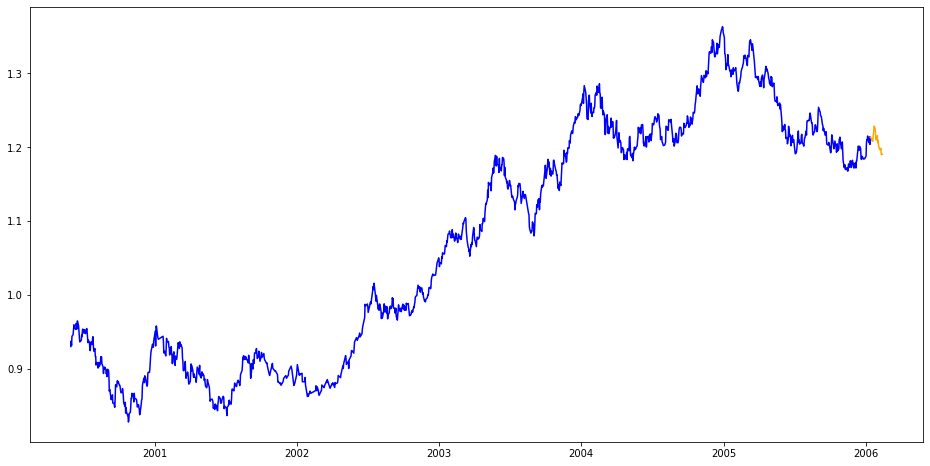

In [126]:
# This plot confirms that our function works properly.
# The gap between the train and test is to be expected
# because we aren't connecting the dots between our
# 107th and 108th observations.

train_test_plot(train, test)

In [127]:
len(train), len(test)

(1364, 22)

In [129]:
# train.reshape(-1,1)

In [155]:
for p in range(4):
    for d in range(4):
        for q in range(4):
            print(f"len of train: {len(train.iloc[p:-1])}")
            arima = ARIMA(endog = train.iloc[p:-1].astype('float32'), order = (p, d, q)) # (p, d, q)
            model = arima.fit()
            preds = model.predict()
            print(preds[0])
            print(f"len of pred: {len(preds)}")
            print(f'The R^2 score for (p = {p}, d = {d}, q = {q}) is {r2_score(train, preds)}.')

len of train: 1363
date
2000-05-30    0.9302
2000-05-31    0.9377
2000-06-01    0.9315
2000-06-02    0.9440
2000-06-05    0.9463
Name: close, dtype: float64
1.0843181908130646
len of pred: 1363


/Users/stuartdaw/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:218: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


ValueError: Found input variables with inconsistent numbers of samples: [1364, 1363]

In [105]:
import time
t0 = time.time()
final_mse = 10000000000000
final_S = 0
final_D = 0
final_P = 0
final_Q = 0

for S in range(310, 380):
    for D in range(4):
        for P in range(4):
            for Q in range(4):
                print(f'Checking ({P}, {D}, {Q}, {S}) at {round(time.time() - t0)} seconds.')
                try:
                    sarima = SARIMAX(endog = train['close'].dropna(),
                                     order = (2, 0, 2),
                                     seasonal_order = (P, D, Q, S)).fit()

                    sarima_pred = sarima.predict(start=start, end=end)

                    if mean_squared_error(test_values, sarima_pred) < final_mse:
                        final_mse = mean_squared_error(test_values, sarima_pred)
                        final_S = S
                        final_D = D
                        final_P = P
                        final_Q = Q

                    print(f'We just fit a SARIMAX(2, 0, 2)x({P}, {D}, {Q}, {S}) model with {mean_squared_error(test_values, sarima_pred)} MSE.')

                except:
                    pass

print(f'The final model is SARIMAX(2, 0, 2)x({final_P}, {final_D}, {final_Q}, {final_S}).')

Checking (0, 0, 0, 310) at 0 seconds.
Checking (0, 0, 1, 310) at 0 seconds.
Checking (0, 0, 2, 310) at 0 seconds.
Checking (0, 0, 3, 310) at 0 seconds.
Checking (1, 0, 0, 310) at 0 seconds.
Checking (1, 0, 1, 310) at 0 seconds.
Checking (1, 0, 2, 310) at 0 seconds.
Checking (1, 0, 3, 310) at 0 seconds.
Checking (2, 0, 0, 310) at 0 seconds.
Checking (2, 0, 1, 310) at 0 seconds.
Checking (2, 0, 2, 310) at 0 seconds.
Checking (2, 0, 3, 310) at 0 seconds.
Checking (3, 0, 0, 310) at 0 seconds.
Checking (3, 0, 1, 310) at 0 seconds.
Checking (3, 0, 2, 310) at 0 seconds.
Checking (3, 0, 3, 310) at 0 seconds.
Checking (0, 1, 0, 310) at 0 seconds.
Checking (0, 1, 1, 310) at 0 seconds.
Checking (0, 1, 2, 310) at 0 seconds.
Checking (0, 1, 3, 310) at 0 seconds.
Checking (1, 1, 0, 310) at 0 seconds.
Checking (1, 1, 1, 310) at 0 seconds.
Checking (1, 1, 2, 310) at 0 seconds.
Checking (1, 1, 3, 310) at 0 seconds.
Checking (2, 1, 0, 310) at 0 seconds.
Checking (2, 1, 1, 310) at 0 seconds.
Checking (2,

Checking (3, 2, 1, 334) at 0 seconds.
Checking (3, 2, 2, 334) at 0 seconds.
Checking (3, 2, 3, 334) at 0 seconds.
Checking (0, 3, 0, 334) at 0 seconds.
Checking (0, 3, 1, 334) at 0 seconds.
Checking (0, 3, 2, 334) at 0 seconds.
Checking (0, 3, 3, 334) at 0 seconds.
Checking (1, 3, 0, 334) at 0 seconds.
Checking (1, 3, 1, 334) at 0 seconds.
Checking (1, 3, 2, 334) at 0 seconds.
Checking (1, 3, 3, 334) at 0 seconds.
Checking (2, 3, 0, 334) at 0 seconds.
Checking (2, 3, 1, 334) at 0 seconds.
Checking (2, 3, 2, 334) at 0 seconds.
Checking (2, 3, 3, 334) at 0 seconds.
Checking (3, 3, 0, 334) at 0 seconds.
Checking (3, 3, 1, 334) at 0 seconds.
Checking (3, 3, 2, 334) at 0 seconds.
Checking (3, 3, 3, 334) at 0 seconds.
Checking (0, 0, 0, 335) at 0 seconds.
Checking (0, 0, 1, 335) at 0 seconds.
Checking (0, 0, 2, 335) at 0 seconds.
Checking (0, 0, 3, 335) at 0 seconds.
Checking (1, 0, 0, 335) at 0 seconds.
Checking (1, 0, 1, 335) at 0 seconds.
Checking (1, 0, 2, 335) at 0 seconds.
Checking (1,

Checking (2, 0, 0, 358) at 0 seconds.
Checking (2, 0, 1, 358) at 0 seconds.
Checking (2, 0, 2, 358) at 0 seconds.
Checking (2, 0, 3, 358) at 0 seconds.
Checking (3, 0, 0, 358) at 0 seconds.
Checking (3, 0, 1, 358) at 0 seconds.
Checking (3, 0, 2, 358) at 0 seconds.
Checking (3, 0, 3, 358) at 0 seconds.
Checking (0, 1, 0, 358) at 0 seconds.
Checking (0, 1, 1, 358) at 0 seconds.
Checking (0, 1, 2, 358) at 0 seconds.
Checking (0, 1, 3, 358) at 0 seconds.
Checking (1, 1, 0, 358) at 0 seconds.
Checking (1, 1, 1, 358) at 0 seconds.
Checking (1, 1, 2, 358) at 0 seconds.
Checking (1, 1, 3, 358) at 0 seconds.
Checking (2, 1, 0, 358) at 0 seconds.
Checking (2, 1, 1, 358) at 0 seconds.
Checking (2, 1, 2, 358) at 0 seconds.
Checking (2, 1, 3, 358) at 0 seconds.
Checking (3, 1, 0, 358) at 0 seconds.
Checking (3, 1, 1, 358) at 0 seconds.
Checking (3, 1, 2, 358) at 0 seconds.
Checking (3, 1, 3, 358) at 0 seconds.
Checking (0, 2, 0, 358) at 0 seconds.
Checking (0, 2, 1, 358) at 0 seconds.
Checking (0,